# Supervised Learning: Predicting Depression Severity

This notebook applies supervised machine learning to classify depression severity using health and demographic data from the 2021–2023 NHANES questionnaire. The outcome variable is the PHQ-9 total score (`PHQ9_TOTAL`), a validated screening tool widely used in clinical and public health settings.

The dataset (`sl_seqn_demo.csv`) includes cleaned binary, ordinal, and continuous variables. Each row represents an individual respondent. A derived feature, `Median_Income`, is added using external census data to estimate socioeconomic status based on race, education, and gender.

Three classification models are developed and evaluated:
- **Logistic Regression** - interpretable and efficient
- **Random Forest** - capable of capturing nonlinear relationships and feature interactions
- **Support Vector Machine (SVM)** - margin-based classification suitable for high-dimensional inputs

All models rely on a shared set of predictors selected for their relevance to depression risk. These include:
- Demographic and household characteristics
- Insurance coverage and healthcare access
- Sleep duration and anxiety indicators

Model evaluation is conducted using stratified cross-validation and a held-out test set. Performance metrics include F1 score, accuracy, and macro-averaged ROC-AUC. The notebook concludes with SHAP-based interpretation and structured failure analysis to highlight common errors and areas for improvement.


In [1]:
import warnings

# Suppress common warnings during modeling
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
import pandas as pd

# Load the updated modeling dataset
df = pd.read_csv("../data/seqn_demo/sl_seqn_demo.csv")

# Show the first few rows
df.head()


,SEQN,SDDSRVYR,RIDSTATR,Gender,Age in years at screening,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,Covered by state-sponsored health plan,Time when no insurance in past year?,Routine place to go for healthcare,Type place most often go for healthcare,Past 12 months had video conf w/Dr?,Seen mental health professional/past yr,Monthly poverty index,Sleep hours - weekdays or workdays,Sleep hours - weekends,PHQ9_TOTAL
0,130391.0,12.0,2.0,1,33,NaN,3.0,3.0,2.0,NaN,...,0,0,1,1,0,0,0.94,7.5,7.5,24.0
1,130397.0,12.0,2.0,1,67,NaN,3.0,3.0,1.0,NaN,...,0,0,1,1,0,0,3.28,8.0,8.0,8.0
2,130426.0,12.0,2.0,0,67,NaN,1.0,1.0,1.0,NaN,...,0,0,1,1,0,0,NaN,6.0,6.0,11.0
3,130457.0,12.0,2.0,1,38,NaN,3.0,3.0,1.0,NaN,...,0,0,1,1,1,1,5.00,8.5,13.5,14.0
4,130596.0,12.0,2.0,1,66,NaN,2.0,2.0,1.0,NaN,...,0,0,0,0,0,0,NaN,6.0,8.0,8.0


## Target Variable Setup

The target variable in this classification task is a categorized version of the PHQ-9 total score. This score ranges from 0 to 27 and is commonly used in clinical and public health settings to assess depression severity.

For modeling purposes, the score is grouped into five standard severity categories:

| PHQ-9 Score | Category             |
|-------------|----------------------|
| 0–4         | None or Minimal      |
| 5–9         | Mild                 |
| 10–14       | Moderate             |
| 15–19       | Moderately Severe    |
| 20–27       | Severe               |

These categories serve as the labels for the classification models, allowing the prediction of depression severity level for each participant.


In [3]:
# Bin PHQ-9 scores into standard severity categories for classification
bins = [-1, 4, 9, 14, 19, 27]
labels = ["None/Minimal", "Mild", "Moderate", "Moderately Severe", "Severe"]
df["target_cls"] = pd.cut(df["PHQ9_TOTAL"], bins=bins, labels=labels)


In [4]:
# List of predictor column names
predictors = [
    "Age in years at screening",
    "Monthly poverty index",
    "Total number of people in the Household",
    "Education level - Adults 20+",
    "Covered by health insurance",
    "Covered by private insurance",
    "Covered by Medicare",
    "Covered by Medi-Gap",
    "Covered by Medicaid",
    "Covered by military health care",
    "Covered by state-sponsored health plan",
    "Time when no insurance in past year?",
    "Seen mental health professional/past yr",
    "Past 12 months had video conf w/Dr?",
    "Routine place to go for healthcare",
    "Type place most often go for healthcare",
    "Sleep hours - weekdays or workdays",
    "Sleep hours - weekends",
    "How often feel worried/nervous/anxious"
]

# Check missing values in predictors
missing_predictors = df[predictors].isnull().sum()

# Check missing values in targets
missing_target_cls = df["target_cls"].isnull().sum()

print("Missing values in predictors:\n", missing_predictors)
print("Missing values in classification target:", missing_target_cls)


Missing values in predictors:
 Age in years at screening                   0
Monthly poverty index                      91
Total number of people in the Household     0
Education level - Adults 20+                0
Covered by health insurance                 0
Covered by private insurance                0
Covered by Medicare                         0
Covered by Medi-Gap                         0
Covered by Medicaid                         0
Covered by military health care             0
Covered by state-sponsored health plan      0
Time when no insurance in past year?        0
Seen mental health professional/past yr     0
Past 12 months had video conf w/Dr?         0
Routine place to go for healthcare          0
Type place most often go for healthcare     0
Sleep hours - weekdays or workdays         10
Sleep hours - weekends                     11
How often feel worried/nervous/anxious      0
dtype: int64
Missing values in classification target: 0


## Estimating Income from Census Reference

A new feature, `Median_Income`, is created to enrich the dataset’s socioeconomic context. This variable is not reported directly in NHANES but is estimated using U.S. Census data based on each participant’s demographic profile.

Each respondent is assigned a typical income value using the following attributes:
- Race
- Education level
- Gender

This estimation method is adapted from Brandon Fox’s demographic-matching strategy:
- NHANES demographic codes are mapped to grouped census categories
- Median income is assigned using an exact match from the reference file
- If no match is found, the overall median income across all groups is used as a fallback

The resulting feature serves as a proxy for household income, offering a consistent and interpretable measure of socioeconomic status without relying on self-reported financial data.


In [5]:
# Load census-based income reference
income_reference = pd.read_csv("../data/external/income_reference.csv")

# Load demographic inputs used for matching
demo = pd.read_csv("../data/seqn_demo/sl_seqn_demo.csv")

# Keep relevant columns and rename them
demo_filtered = demo[["SEQN", "RIDRETH3", "Education level - Adults 20+", "Gender"]].dropna()
demo_filtered = demo_filtered.rename(columns={
    "RIDRETH3": "Race",
    "Education level - Adults 20+": "Education"
})

# Map numeric codes to readable groupings
race_map = {
    1: "White", 
    2: "Hispanic (any race)", 
    3: "White, not Hispanic", 
    4: "Black", 
    6: "Asian", 
    7: "Other"
}
edu_map = {
    1: "No high school diploma",
    2: "No high school diploma",
    3: "High school, no college",
    4: "Some college",
    5: "Bachelor's degree or higher"
}
gender_map = {1: "Male", 2: "Female"}

demo_filtered["Race_Group"] = demo_filtered["Race"].map(race_map)
demo_filtered["Edu_Group"] = demo_filtered["Education"].map(edu_map)
demo_filtered["Gender_Label"] = demo_filtered["Gender"].map(gender_map)

# Merge demographic groups with income reference
demo_income = demo_filtered.merge(
    income_reference,
    on=["Race_Group", "Edu_Group", "Gender_Label"],
    how="left"
)

# Fill in any unmatched groups with the overall mean
mean_income = income_reference["Median_Income"].mean()
demo_income["Median_Income"] = demo_income["Median_Income"].fillna(mean_income)

# Merge income estimates back into modeling dataset
df = df.merge(demo_income[["SEQN", "Median_Income"]], on="SEQN", how="left")

# Add to predictor list if not already there
if "Median_Income" not in predictors:
    predictors.append("Median_Income")

# Optional: Check final distribution
#df["Median_Income"].describe()


## Handling Missing Values

A few predictor variables contain missing values that must be addressed before model training. These include:

- `Monthly poverty index` (91 missing)
- `Sleep hours - weekdays or workdays` (10 missing)
- `Sleep hours - weekends` (11 missing)

To retain as many observations as possible without distorting the data, median imputation is applied. Median values are less sensitive to skewed distributions and preserve the overall structure of the feature set.

No missing values were found in `Median_Income` following the census-based merge, so no imputation is required for that feature.


In [6]:
# Median imputation for predictors with missing values
df["Monthly poverty index"] = df["Monthly poverty index"].fillna(df["Monthly poverty index"].median())
df["Sleep hours - weekdays or workdays"] = df["Sleep hours - weekdays or workdays"].fillna(df["Sleep hours - weekdays or workdays"].median())
df["Sleep hours - weekends"] = df["Sleep hours - weekends"].fillna(df["Sleep hours - weekends"].median())


## Train/Test Split

The dataset is split into training and test sets using an 80/20 ratio. Because the classification target (`target_cls`) includes multiple depression severity levels with unequal representation, stratified sampling is used to maintain proportional class distributions.

This helps ensure that model performance on the test set reflects realistic class frequencies and avoids bias from underrepresented categories.


In [7]:
from sklearn.model_selection import train_test_split

# Define feature matrix (X) and classification target (y)
X = df[predictors]
y_cls = df["target_cls"]

# Stratified 80/20 train-test split for classification
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)


## Cross-Validation Setup

Each classification model is evaluated using stratified 5-fold cross-validation. This approach ensures that each fold preserves the original distribution of PHQ-9 severity categories, which helps prevent biased performance estimates in imbalanced settings.

Hyperparameter tuning is performed within this cross-validation framework using `GridSearchCV`, enabling each model to identify the most effective configuration based on weighted F1 score.

The final test set remains completely separate and is only used for evaluation after tuning.


In [8]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Set stratified 5-fold cross-validation for all classifiers
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

### Hyperparameter Strategy and Ethical Rationale

The hyperparameter grids are designed to balance accuracy, interpretability, and fairness, especially in the context of mental health classification:

- **Class weighting** addresses the underrepresentation of higher-risk groups such as Severe or Moderately Severe.
- **Tree depth and leaf size** are limited to reduce overfitting to rare profiles.
- **Regularization and margin control** support generalization across individuals with different risk factors.
- **Bootstrap sampling** (used in Random Forest) maintains data diversity without over-reliance on specific cases.
- **Kernel and gamma tuning** (used in SVM) introduces flexibility while controlling model complexity.

The tuning process emphasizes transparency and reproducibility, favoring thoughtful generalization over marginal performance gains. Black-box optimization techniques were intentionally avoided.


## Logistic Regression (Classification)

Logistic Regression is used as a baseline model for predicting PHQ-9 severity categories. It offers interpretability and efficient training, making it well-suited for health applications where transparency is a priority.

Features are standardized before modeling using a pipeline. Hyperparameters are tuned using stratified 5-fold cross-validation on the training data. The final model is evaluated on the held-out test set using weighted F1 score, accuracy, and macro-averaged ROC-AUC.


In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import matplotlib.pyplot as plt

# Create modeling pipeline
logreg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, random_state=42))
])

# Hyperparameter grid
param_grid_logreg = {
    "logreg__C": [0.001, 0.01, 0.1, 1, 10, 100],       # Regularization strength
    "logreg__penalty": ["l2"],                        # L2 regularization for stability
    "logreg__solver": ["lbfgs"],                      # Supports multiclass with l2
    "logreg__class_weight": [None, "balanced"]        # Optional reweighting for class imbalance
}

# Grid search with stratified 5-fold CV
grid_logreg = GridSearchCV(
    estimator=logreg_pipeline,
    param_grid=param_grid_logreg,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1
)

# Fit model on training data
grid_logreg.fit(X_train_cls, y_train_cls)

# Best parameter configuration
print("Best Logistic Regression Params:", grid_logreg.best_params_)

# Predict on test set
best_logreg_model = grid_logreg.best_estimator_
y_pred_logreg = best_logreg_model.predict(X_test_cls)
y_proba_logreg = best_logreg_model.predict_proba(X_test_cls)

Best Logistic Regression Params: {'logreg__C': 1, 'logreg__class_weight': None, 'logreg__penalty': 'l2', 'logreg__solver': 'lbfgs'}


                   precision    recall  f1-score   support

             Mild       0.29      0.30      0.30        30
         Moderate       0.36      0.47      0.41        38
Moderately Severe       0.25      0.17      0.20        18
           Severe       0.00      0.00      0.00         8

         accuracy                           0.32        94
        macro avg       0.23      0.24      0.23        94
     weighted avg       0.29      0.32      0.30        94



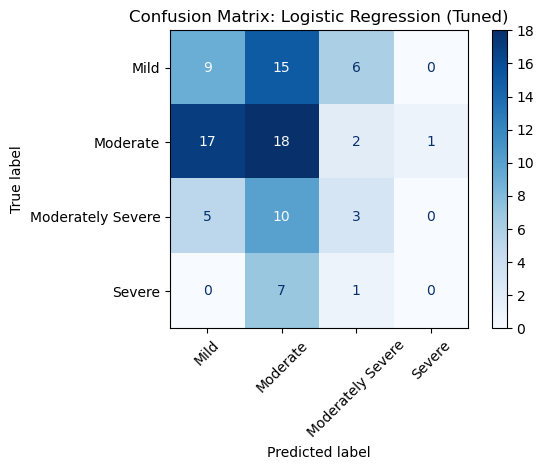

Test ROC-AUC (OvR, macro): 0.568


In [10]:
# Classification report
print(classification_report(y_test_cls, y_pred_logreg, zero_division=0))

# Confusion matrix
cm_logreg = confusion_matrix(y_test_cls, y_pred_logreg, labels=best_logreg_model.classes_)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=best_logreg_model.classes_)
disp_logreg.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: Logistic Regression (Tuned)")
plt.tight_layout()
plt.show()

# ROC-AUC (macro-average)
auc_logreg = roc_auc_score(y_test_cls, y_proba_logreg, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {auc_logreg:.3f}")

### Logistic Regression Performance Summary

The final Logistic Regression model used L2 regularization with `C=1` and no class weighting. On the held-out test set, the model achieved:

- **Accuracy**: 0.32  
- **Weighted F1 Score**: 0.30  
- **Macro-Averaged ROC-AUC**: 0.568

Most correct predictions occurred in the Mild and Moderate categories. Precision and recall dropped significantly for the Moderately Severe group, and the model failed to identify any Severe cases.

The confusion matrix indicates a strong bias toward mid-range severity predictions, likely due to overlapping symptoms and class imbalance. These results suggest that while logistic regression is interpretable, its linear decision boundaries may not capture the complexity of higher-risk profiles.


## Random Forest (Classification)

Random Forest is an ensemble model that combines multiple decision trees to capture complex interactions between predictors. It is well-suited to imbalanced and nonlinear health data and provides interpretable feature importance rankings.

Hyperparameters are tuned using stratified 5-fold cross-validation on the training set. Evaluation is based on F1 score, accuracy, and macro-averaged ROC-AUC.


In [11]:
from sklearn.ensemble import RandomForestClassifier

# Define parameter grid for tuning
param_grid_rf = {
    "n_estimators": [100, 300, 500],               # More trees = better stability
    "max_depth": [None, 10, 20, 40],               # Limits overfitting from deep trees
    "min_samples_split": [2, 5, 10],               # Higher = fewer splits, more generalization
    "min_samples_leaf": [1, 2, 4],                 # Prevents tiny, noisy leaves
    "bootstrap": [True],                           # Boosts diversity through sampling
    "class_weight": [None, "balanced_subsample"]   # Helps with imbalanced target classes
}

# Initialize model
rf_classifier = RandomForestClassifier(random_state=42)

# GridSearchCV with stratified 5-fold CV
grid_rf = GridSearchCV(
    estimator=rf_classifier,
    param_grid=param_grid_rf,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1
)

# Fit model on training data
grid_rf.fit(X_train_cls, y_train_cls)

# Best parameters
print("Best Random Forest Params:", grid_rf.best_params_)

Best Random Forest Params: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 500}


                   precision    recall  f1-score   support

             Mild       0.24      0.30      0.27        30
         Moderate       0.42      0.29      0.34        38
Moderately Severe       0.33      0.39      0.36        18
           Severe       0.20      0.25      0.22         8

         accuracy                           0.31        94
        macro avg       0.30      0.31      0.30        94
     weighted avg       0.33      0.31      0.31        94



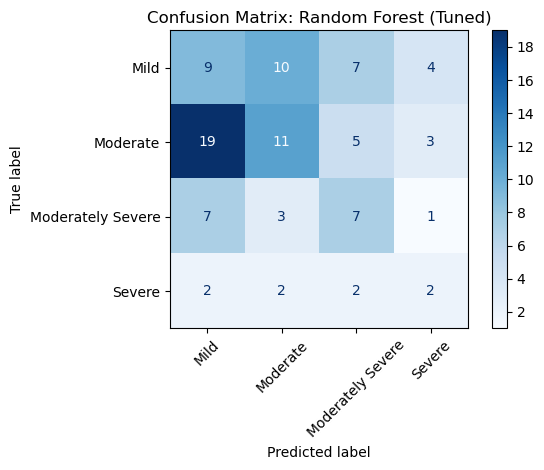

Test ROC-AUC (OvR, macro): 0.588


In [12]:
# Evaluate on test set
best_rf_model = grid_rf.best_estimator_
y_pred_rf = best_rf_model.predict(X_test_cls)
y_proba_rf = best_rf_model.predict_proba(X_test_cls)

# Classification report
print(classification_report(y_test_cls, y_pred_rf, zero_division=0))

# Confusion matrix
cm_rf = confusion_matrix(y_test_cls, y_pred_rf, labels=best_rf_model.classes_)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=best_rf_model.classes_)
disp_rf.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: Random Forest (Tuned)")
plt.tight_layout()
plt.show()

# ROC-AUC score (macro)
auc_score_rf = roc_auc_score(y_test_cls, y_proba_rf, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {auc_score_rf:.3f}")

### Random Forest Performance Summary

The tuned Random Forest model used 500 trees with `max_depth=10`, `min_samples_leaf=4`, and `class_weight="balanced_subsample"`. It achieved the following performance on the test set:

- **Accuracy**: 0.31  
- **Weighted F1 Score**: 0.31  
- **Macro-Averaged ROC-AUC**: 0.588

The confusion matrix shows improved detection of Moderate and Moderately Severe cases relative to logistic regression. Precision was highest for Moderate, while recall for the Severe group improved slightly, with the model correctly identifying two out of eight cases.

Overall, the Random Forest classifier showed a more balanced distribution of predictions across classes. However, its broader coverage came at the cost of slightly lower precision, suggesting the model was more willing to "guess" higher-risk categories - an ethically defensible tradeoff in health screening contexts.

This model's ability to incorporate non-linear feature interactions makes it well suited for interpreting risk patterns, especially when supported by follow-up feature importance and SHAP analyses.


### Support Vector Machine (Classification)

Support Vector Machines (SVM) are margin-based classifiers designed to find the optimal boundary that separates classes. With the right kernel, they can capture complex patterns in high-dimensional health data. This model is tuned using stratified 5-fold cross-validation, and evaluated on a held-out test set using weighted F1 and macro-averaged ROC-AUC.


In [13]:
from sklearn.svm import SVC

# Pipeline with scaler and SVC
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, random_state=42))
])

# Parameter grid 
param_grid_svm = {
    "svm__C": [0.01, 0.1, 1, 5, 10],               # Controls margin vs. misclassification
    "svm__kernel": ["linear", "rbf"],              # Chooses simple vs. flexible boundary
    "svm__gamma": ["scale", 0.01, 0.001],          # Higher = tighter curve (RBF only)
    "svm__class_weight": [None, "balanced"]        # Gives more weight to rare classes
}

# Grid search with stratified cross-validation
grid_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid_svm,
    cv=cv,
    scoring="f1_weighted",
    n_jobs=-1
)

# Fit on training data
grid_svm.fit(X_train_cls, y_train_cls)

# Display best parameters
print("Best SVM Params:", grid_svm.best_params_)


Best SVM Params: {'svm__C': 10, 'svm__class_weight': None, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}


                   precision    recall  f1-score   support

             Mild       0.29      0.33      0.31        30
         Moderate       0.38      0.47      0.42        38
Moderately Severe       0.20      0.11      0.14        18
           Severe       0.00      0.00      0.00         8

         accuracy                           0.32        94
        macro avg       0.22      0.23      0.22        94
     weighted avg       0.28      0.32      0.30        94



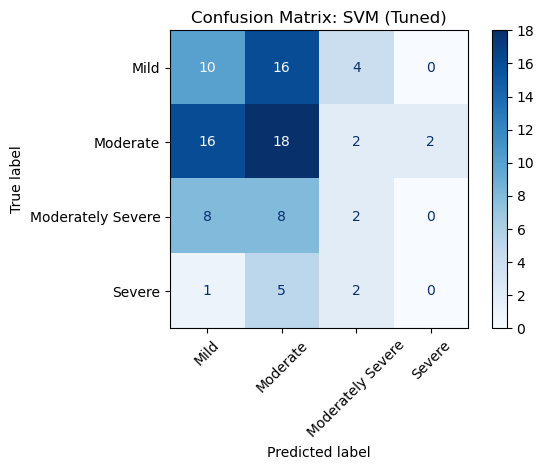

Test ROC-AUC (OvR, macro): 0.549


In [14]:
# Evaluate on test set
best_svm_model = grid_svm.best_estimator_
y_pred_svm = best_svm_model.predict(X_test_cls)
y_proba_svm = best_svm_model.predict_proba(X_test_cls)

# Classification report
print(classification_report(y_test_cls, y_pred_svm, zero_division=0))

# Confusion matrix
cm_svm = confusion_matrix(y_test_cls, y_pred_svm, labels=best_svm_model.classes_)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=best_svm_model.classes_)
disp_svm.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: SVM (Tuned)")
plt.tight_layout()
plt.show()

# Macro-averaged ROC-AUC
auc_score_svm = roc_auc_score(y_test_cls, y_proba_svm, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {auc_score_svm:.3f}")


### Support Vector Machine (SVM) Performance Summary

The best SVM model used a linear kernel with `C=10` and no class weighting. On the test set, it achieved:

- **Accuracy**: 0.32  
- **Weighted F1 Score**: 0.30  
- **Macro-Averaged ROC-AUC**: 0.549

The model performed best for Moderate cases but showed weak recall for more severe categories. Severe cases were not correctly identified, likely due to class imbalance and overlapping features. Precision and recall dropped significantly as severity increased.

A linear kernel preserved interpretability but may have limited the model’s flexibility. Future iterations could explore nonlinear kernels or class-aware strategies to improve recall for higher-risk groups.


## Model Performance Summary

### Classification Models

| Model                | CV Accuracy     | CV F1 (Weighted) | CV ROC-AUC (OvR) | Test Accuracy | Test F1 (Weighted) | Test ROC-AUC (OvR) |
|----------------------|-----------------|------------------|------------------|---------------|--------------------|--------------------|
| Logistic Regression  | 0.386 ± 0.040   | 0.361 ± 0.047    | 0.619 ± 0.009    | 0.32          | 0.30               | 0.568              |
| Random Forest        | 0.362 ± 0.039   | 0.323 ± 0.046    | 0.584 ± 0.026    | 0.31          | 0.31               | 0.588              |
| SVM (Linear)         | 0.376 ± 0.049   | 0.342 ± 0.054    | 0.628 ± 0.024    | 0.32          | 0.30               | 0.549              |


Overall, all three classifiers showed similar test accuracy, with Logistic Regression and SVM slightly outperforming Random Forest on ROC-AUC. However, none of the models were able to consistently detect Severe cases, highlighting the challenges of class imbalance and overlapping features in real-world depression screening.

Random Forest provided the most balanced predictions across classes, while SVM offered a tradeoff between flexibility and interpretability. Logistic Regression, though simple, remained competitive and transparent - an asset in health settings where interpretability matters.

These results suggest that future iterations could benefit from ensemble strategies or class-aware optimization to better support high-risk groups.


### Feature Importance: Random Forest

The Random Forest model identifies the features that contributed most to classifying PHQ-9 severity levels. The chart below displays the top 15 features ranked by their average decrease in impurity across the ensemble.

Key observations include:

- **Monthly poverty index** and **Age in years at screening** were the strongest predictors overall.
- **Sleep patterns** and **perceived anxiety** indicators also showed consistent influence, supporting known behavioral links to depression.
- **Household size** and **education level** contributed alongside access-related features like insurance and healthcare setting.
- **Median_Income**, derived from census-based demographic matching, appeared as a secondary but meaningful structural predictor.

These results highlight the multifaceted nature of depression severity, combining demographic, behavioral, and socioeconomic factors. Feature transparency enables clearer communication of model decisions in public health and policy settings.


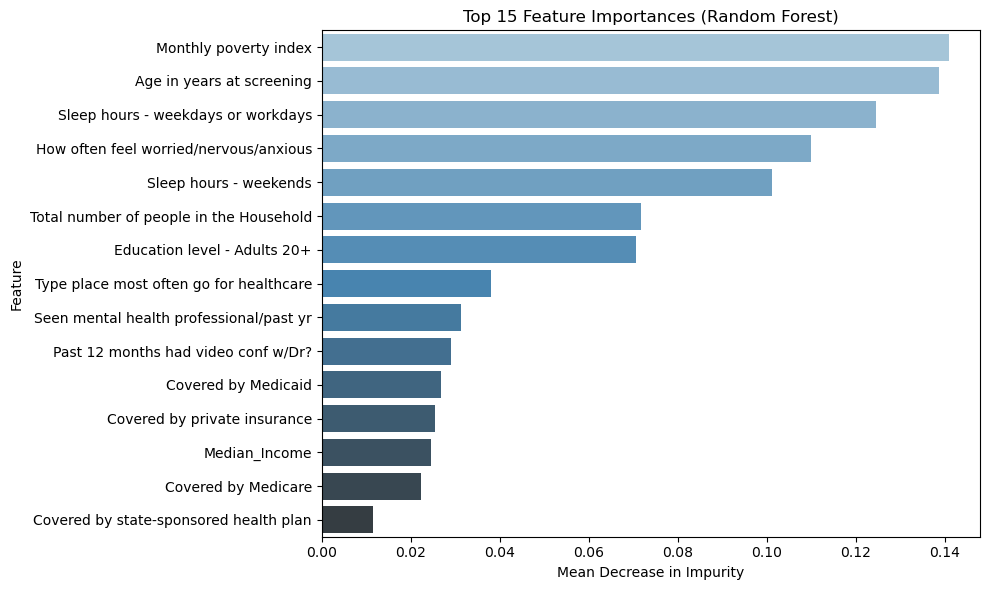

In [15]:
# Extract feature importances from final Random Forest model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get importances from the fitted model directly
importances = best_rf_model.feature_importances_
feature_names = X.columns

# Build DataFrame
feat_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Plot top 15
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df.head(15), x="Importance", y="Feature", palette="Blues_d")
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Mean Decrease in Impurity")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Sensitivity Analysis: Socioeconomic Predictors Only

To assess the contribution of socioeconomic context alone, a sensitivity analysis was conducted using a reduced set of features related to income, education, and insurance status. This isolates the influence of structural predictors without behavioral or clinical variables.

The same Random Forest configuration from the main model was applied.

#### Socioeconomic Variables Used:
- `Monthly poverty index`
- `Median_Income`
- `Education level - Adults 20+`
- All binary insurance coverage variables
- `Time when no insurance in past year?`

The test set performance is shown below.


                   precision    recall  f1-score   support

             Mild       0.29      0.17      0.21        30
         Moderate       0.33      0.39      0.36        38
Moderately Severe       0.21      0.22      0.22        18
           Severe       0.00      0.00      0.00         8

         accuracy                           0.26        94
        macro avg       0.21      0.20      0.20        94
     weighted avg       0.27      0.26      0.25        94



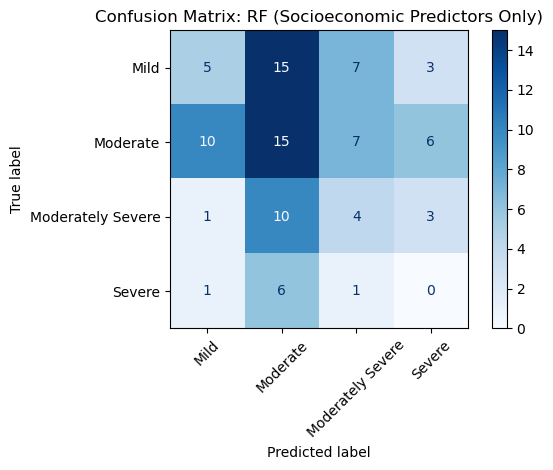

Test ROC-AUC (OvR, macro): 0.504


In [16]:
# Define subset of socioeconomic predictors
socioeconomic_vars = [
    "Monthly poverty index",
    "Median_Income",
    "Education level - Adults 20+",
    "Covered by health insurance",
    "Covered by private insurance",
    "Covered by Medicare",
    "Covered by Medi-Gap",
    "Covered by Medicaid",
    "Covered by military health care",
    "Covered by state-sponsored health plan",
    "Time when no insurance in past year?"
]

# Create new X matrix
X_ses = df[socioeconomic_vars]

# Split again using the same stratified approach
X_train_ses, X_test_ses, y_train_ses, y_test_ses = train_test_split(
    X_ses, y_cls, test_size=0.2, random_state=42, stratify=y_cls
)

# Use same best parameters from tuned full model
rf_ses = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=1,
    class_weight="balanced_subsample",
    bootstrap=True,
    random_state=42
)

# Fit and evaluate
rf_ses.fit(X_train_ses, y_train_ses)
y_pred_ses = rf_ses.predict(X_test_ses)
y_proba_ses = rf_ses.predict_proba(X_test_ses)

# Print classification report
print(classification_report(y_test_ses, y_pred_ses, zero_division=0))

# Confusion matrix
cm_ses = confusion_matrix(y_test_ses, y_pred_ses, labels=rf_ses.classes_)
disp_ses = ConfusionMatrixDisplay(confusion_matrix=cm_ses, display_labels=rf_ses.classes_)
disp_ses.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: RF (Socioeconomic Predictors Only)")
plt.tight_layout()
plt.show()

# ROC-AUC
roc_auc_ses = roc_auc_score(y_test_ses, y_proba_ses, multi_class="ovr", average="macro")
print(f"Test ROC-AUC (OvR, macro): {roc_auc_ses:.3f}")


## Sensitivity Analysis: Socioeconomic Predictors Only

A sensitivity analysis was conducted using only socioeconomic features such as income, insurance coverage, and education. These variables are often available in administrative datasets and help isolate the contribution of financial and access-related factors to depression severity classification.

The same Random Forest model structure and tuned parameters were applied to maintain consistency. When restricted to this subset, the model's performance declined:

- **Test Accuracy:** 0.26  
- **Weighted F1 Score:** 0.25  
- **Macro-Averaged ROC-AUC:** 0.504

Most predictions fell into the Mild and Moderate categories. Severe cases were not correctly identified, and precision for higher-risk groups was low. This suggests that socioeconomic features alone do not provide enough information to classify depression severity reliably.

Behavioral and clinical variables, including sleep patterns and anxiety responses, appear necessary to support accurate and ethical identification of individuals with more severe symptoms.


## Failure Analysis

This section highlights where the tuned Random Forest model most often makes mistakes. Three types of errors were identified using real examples from the test set. Each case reveals specific model limitations and opportunities for improvement.

---

### 1. Adjacent Class Confusion

**Error Type:** Confusing neighboring PHQ-9 severity levels  
**Context:** These mistakes happen when the model predicts a level just above or below the true category. While understandable, such errors can still carry clinical implications.

- **Example:** Row 328 - Labeled *Mild*, Predicted *Moderate*  
  A 63-year-old with stable insurance, moderate sleep, and no extreme feature values. The model predicted one tier higher than the label.

- **Possible Cause:** Overlap in feature values near PHQ-9 score cutoffs  
- **Suggested Fix:** Try ordinal classification methods or add smoothing to account for the gradual nature of severity levels

---

### 2. Underprediction of Severe Cases

**Error Type:** Missing high-risk individuals  
**Context:** The model struggles to correctly identify Severe or Moderately Severe cases, which are especially important to flag in screening settings.

- **Example:** Row 455 - Labeled *Severe*, Predicted *Moderate*  
  An 18-year-old with no regular care provider, high poverty, and limited healthcare access. The model underestimated their risk.

- **Possible Cause:** Imbalanced classes or overly conservative decision boundaries  
- **Suggested Fix:** Tune class weights or use ensemble approaches that boost recall for underrepresented groups

---

### 3. Conflicts with Known Risk Profiles

**Error Type:** Predictions that overlook clear indicators of risk  
**Context:** Some individuals were assigned low severity labels despite having several well-established risk factors.

- **Example:** Row 104 - Labeled *Moderate*, Predicted *Mild*  
  A 43-year-old with only 3.5 hours of sleep, no regular source of care, and prior mental health concerns. These signs were not reflected in the prediction.

- **Possible Cause:** Risk features may have been drowned out by more common patterns during training  
- **Suggested Fix:** Use SHAP or LIME to isolate feature effects, and consider engineering interaction terms to highlight overlapping risks

---

### Ethical Note

Model failures in mental health settings carry real consequences. Misclassifying individuals at higher risk can delay care or lead to missed opportunities for early support. Regular auditing of errors-especially around severe cases-helps ensure that models remain transparent, fair, and usable in real-world public health applications.


In [17]:
# Refit best Random Forest model to full training data
best_rf_model.fit(X_train_cls, y_train_cls)

# Predict on test data
y_pred_rf = best_rf_model.predict(X_test_cls)

# Create a comparison DataFrame
failures_df = X_test_cls.copy()
failures_df["True Label"] = y_test_cls.values
failures_df["Predicted Label"] = y_pred_rf
failures_df["Correct"] = failures_df["True Label"] == failures_df["Predicted Label"]

# Filter for misclassified cases
misclassified_rf = failures_df[~failures_df["Correct"]]

# Display a few misclassified cases for inspection
misclassified_rf.head(10)


,Age in years at screening,Monthly poverty index,Total number of people in the Household,Education level - Adults 20+,Covered by health insurance,Covered by private insurance,Covered by Medicare,Covered by Medi-Gap,Covered by Medicaid,Covered by military health care,...,Past 12 months had video conf w/Dr?,Routine place to go for healthcare,Type place most often go for healthcare,Sleep hours - weekdays or workdays,Sleep hours - weekends,How often feel worried/nervous/anxious,Median_Income,True Label,Predicted Label,Correct
5,36,1.865,5,4,1,0,0,0,0,0,...,0,1,3,7.5,7.5,1,85448.0,Moderate,Severe,False
223,71,2.650,1,4,1,1,1,0,0,0,...,0,1,1,6.5,6.5,2,85448.0,Moderate,Mild,False
417,59,5.000,5,5,0,0,0,0,0,0,...,1,1,1,6.0,10.0,1,112800.0,Moderately Severe,Mild,False
328,63,4.120,1,4,1,1,0,0,0,0,...,0,1,1,6.5,5.5,2,85448.0,Mild,Moderate,False
347,64,1.980,3,3,1,0,0,0,0,0,...,0,1,2,7.5,8.0,2,55810.0,Mild,Moderate,False
351,44,1.990,2,4,1,1,0,0,0,0,...,0,1,1,8.5,10.5,2,85448.0,Moderate,Mild,False
170,21,1.865,1,5,1,1,0,0,0,0,...,1,1,2,8.0,8.0,1,126800.0,Mild,Severe,False
455,18,5.000,3,0,1,1,0,0,0,0,...,0,0,0,8.0,8.0,1,85448.0,Severe,Mild,False
104,43,2.080,3,3,1,1,0,0,0,0,...,0,1,3,3.5,6.0,4,85448.0,Mild,Moderate,False
464,51,4.800,5,4,1,1,0,0,0,0,...,0,1,1,7.5,8.5,4,85448.0,Mild,Moderate,False


### SHAP Explanation for Misclassified Cases

SHAP (SHapley Additive exPlanations) provides case-level insight into how the Random Forest model arrived at each prediction. For selected misclassified individuals, SHAP values reveal which features pushed the model toward the incorrect class and which features held it back.

Each chart below represents a single prediction. Red bars indicate features that increased the model’s confidence in the predicted class, while blue bars show features that worked against it. The length of each bar reflects the strength of that feature’s contribution. These visualizations help explain why the model misclassified certain cases and suggest where refinements may improve accuracy for high-risk groups.


 99%|===================| 257/260 [00:16<00:00]        


Case 1: True Label = Moderate, Predicted Label = Severe


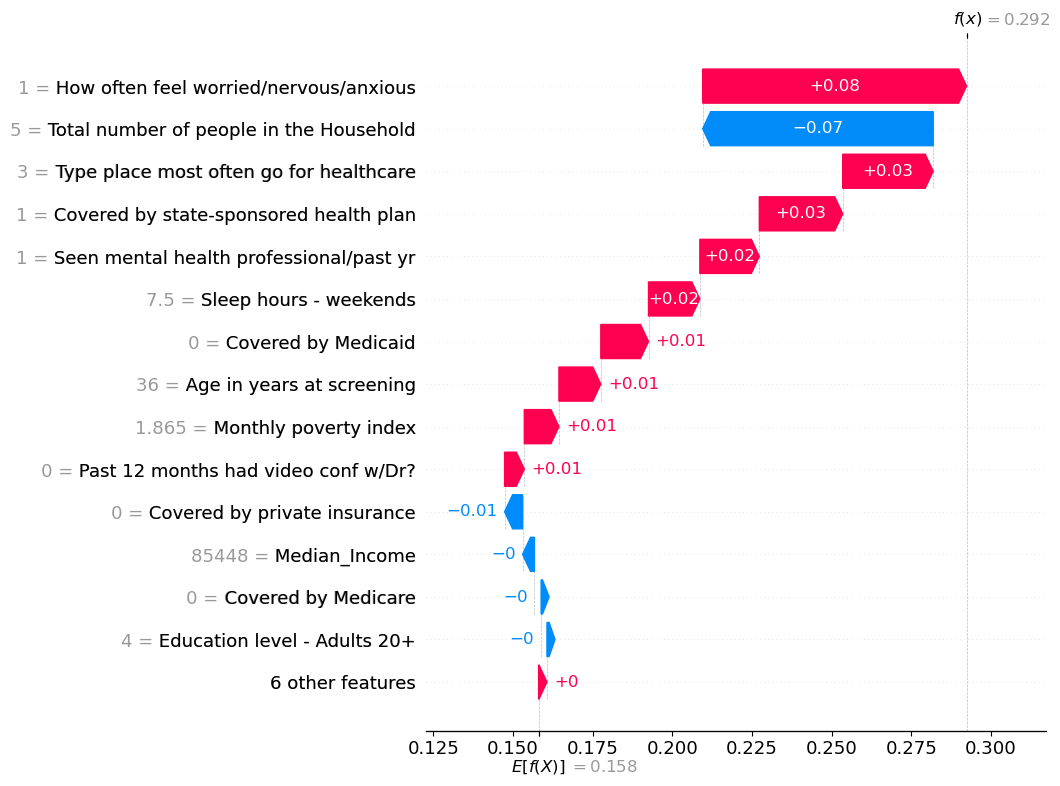


Case 2: True Label = Moderate, Predicted Label = Mild


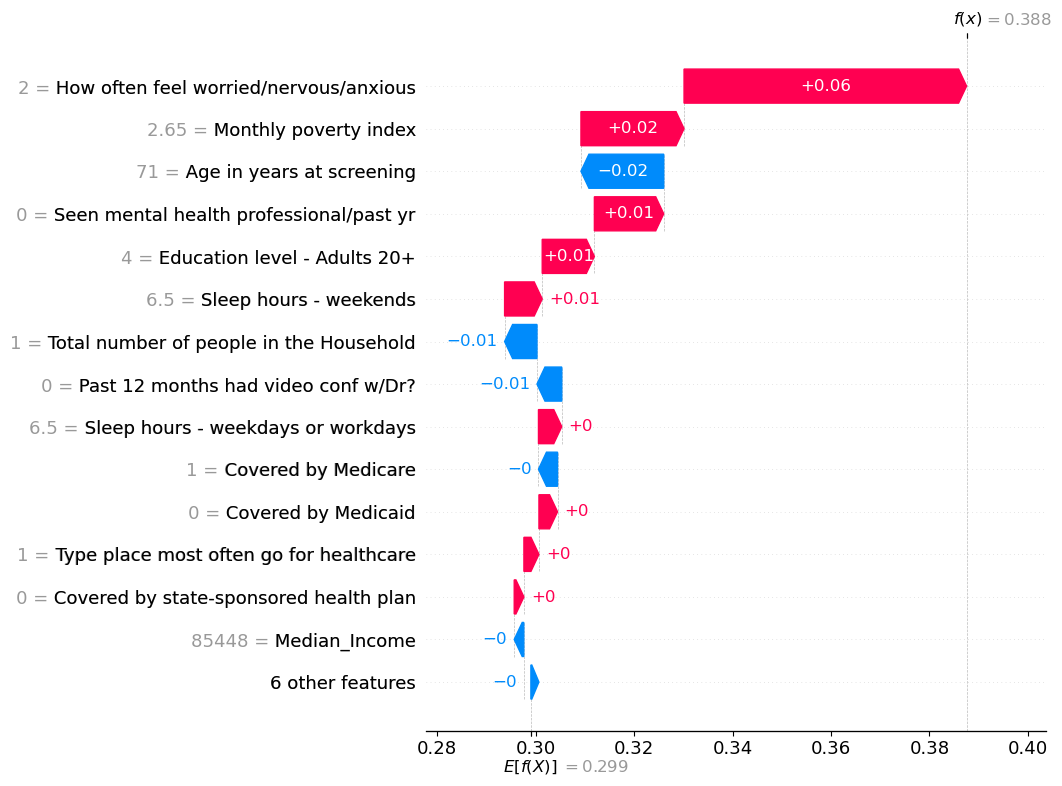


Case 3: True Label = Moderately Severe, Predicted Label = Mild


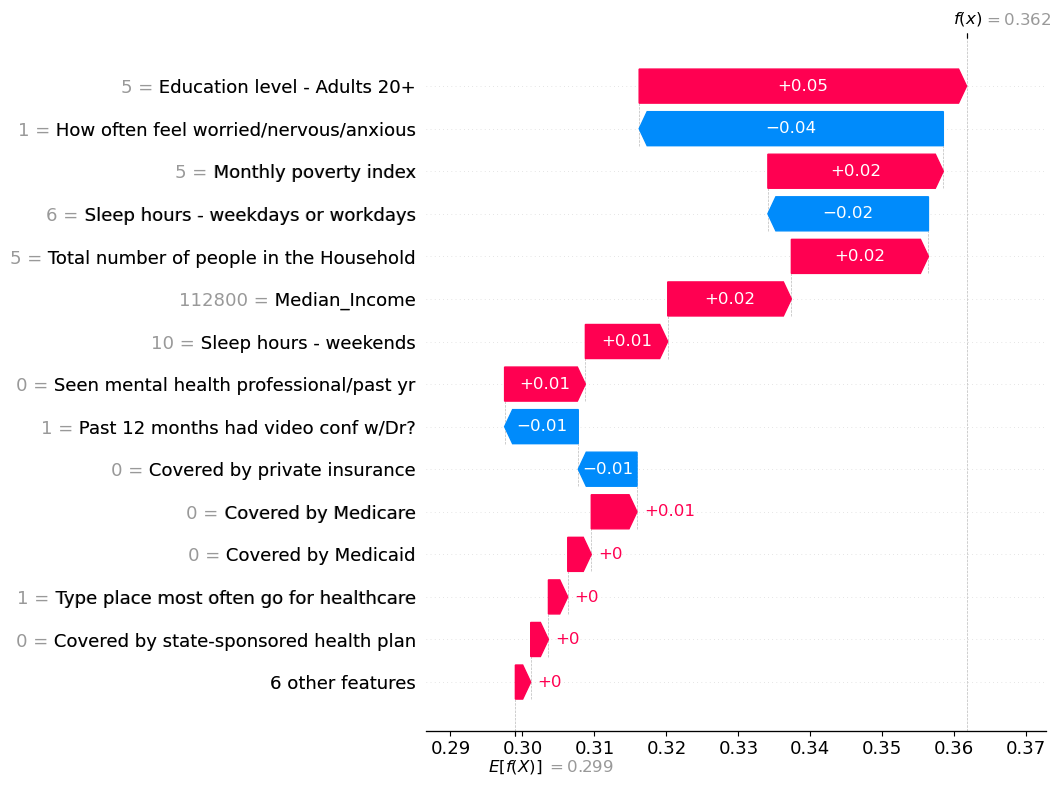

In [18]:
import shap
import matplotlib.pyplot as plt

# Fit best model (if not already)
best_rf_model.fit(X_train_cls, y_train_cls)

# Create SHAP explainer
explainer = shap.Explainer(best_rf_model, X_train_cls)

# Subset to misclassified examples and drop labels
X_misclassified = misclassified_rf.drop(columns=["True Label", "Predicted Label", "Correct"])

# Compute SHAP values
shap_values = explainer(X_misclassified)

# Loop through the first 3 misclassified cases
for i in range(3):
    true_label = misclassified_rf.iloc[i]["True Label"]
    predicted_label = misclassified_rf.iloc[i]["Predicted Label"]
    predicted_class_index = list(best_rf_model.classes_).index(predicted_label)
    
    # Prepare SHAP explanation for the predicted class
    sv = shap_values[i]
    sv.values = shap_values.values[i][:, predicted_class_index]
    sv.base_values = shap_values.base_values[i][predicted_class_index]
    sv.data = shap_values.data[i]

    # Title and plot
    print(f"\nCase {i+1}: True Label = {true_label}, Predicted Label = {predicted_label}")
    shap.plots.waterfall(sv, max_display=15, show=True)


### SHAP Interpretation Summaries

**Case 1**  
**True Label:** Moderate  
**Predicted Label:** Severe  
The model overestimated severity. High reported anxiety, prior mental health visits, and a state-sponsored insurance plan contributed strongly to the misclassification. While weekend sleep hours and Medicaid coverage helped temper the prediction, they were outweighed by features tied to clinical history and care access.

**Case 2**  
**True Label:** Moderate  
**Predicted Label:** Mild  
The model underestimated severity. Anxiety and poverty index pushed the prediction upward, but features like older age, household size, and Medicare coverage reduced the score. Several risk factors had minimal influence, which may explain the downward misclassification despite meaningful signs of risk.

**Case 3**  
**True Label:** Moderately Severe  
**Predicted Label:** Mild  
This borderline case involved multiple muted contributions. Education level, poverty, and income increased the prediction, while anxiety, weekday sleep, and insurance-related variables pulled it down. The feature mix lacked a dominant signal, and key indicators like anxiety and healthcare access did not shift the decision far enough to reach the correct severity level.


In [19]:
import joblib
import os

# Create models directory if it doesn't exist
#os.makedirs("models", exist_ok=True)

# Save best estimators
#joblib.dump(best_logreg_model, "models/best_logreg_alexis.pkl")
#joblib.dump(best_rf_model, "models/best_rf_alexis.pkl")
#joblib.dump(best_svm_model, "models/best_svm_alexis.pkl")
